# VAE Digit Recognition

In [2]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Downloading the dataset

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37579914.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1039925.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8308454.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2560554.94it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [4]:

count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

# Resizing the images from 28x28 to 14x14

In [5]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

Binarizing

In [6]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

# Creating dataloaders

In [7]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
     

# Variational Auto Encoder model

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

# Defining loss, optimizer and LR scheduler

In [9]:

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD
     

# Training and Validating

In [10]:

count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 20):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -52.4661
====> Test set loss: -42.6637
====> Epoch: 2 Average loss: -40.6653
====> Test set loss: -38.8417
====> Epoch: 3 Average loss: -37.8360
====> Test set loss: -36.6282
====> Epoch: 4 Average loss: -36.3688
====> Test set loss: -35.7416
====> Epoch: 5 Average loss: -35.6323
====> Test set loss: -35.3850
====> Epoch: 6 Average loss: -35.1294
====> Test set loss: -34.8816
====> Epoch: 7 Average loss: -34.6680
====> Test set loss: -34.4877
====> Epoch: 8 Average loss: -34.2692
====> Test set loss: -34.2150
====> Epoch: 9 Average loss: -33.9468
====> Test set loss: -33.8878
====> Epoch: 10 Average loss: -33.7231
====> Test set loss: -33.7355
====> Epoch: 11 Average loss: -33.4831
====> Test set loss: -33.6261
====> Epoch: 12 Average loss: -33.2383
====> Test set loss: -33.1700
====> Epoch: 13 Average loss: -33.0417
====> Test set loss: -33.3922
====> Epoch: 14 Average loss: -32.9343
====> Test set loss: -33.2205
====> Epoch: 15 Average loss: -32.7944
====

# Plotting the first and second term of ELBO as a function of weight updates

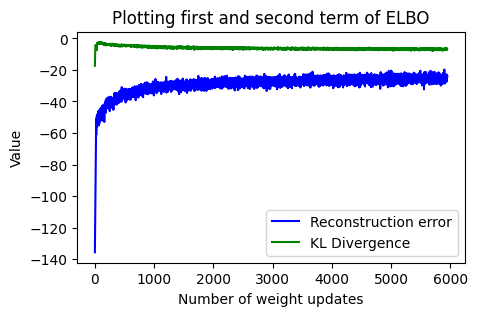

In [11]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

# Visualizing input and output from the VAE from training set

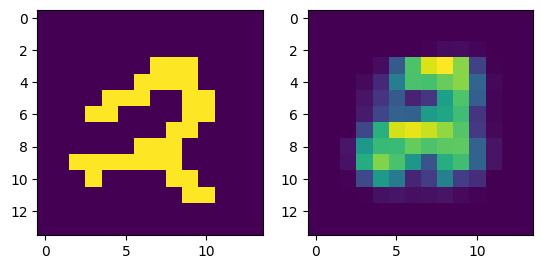

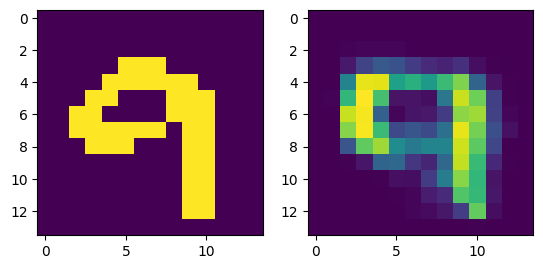

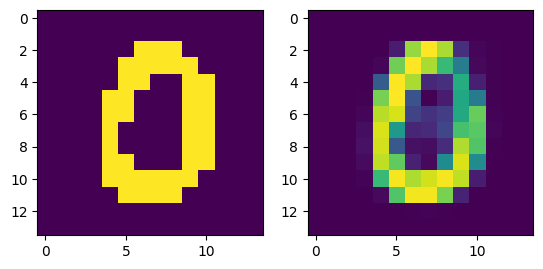

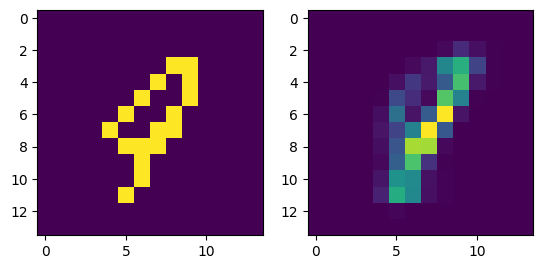

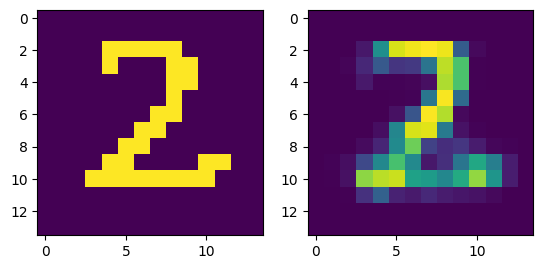

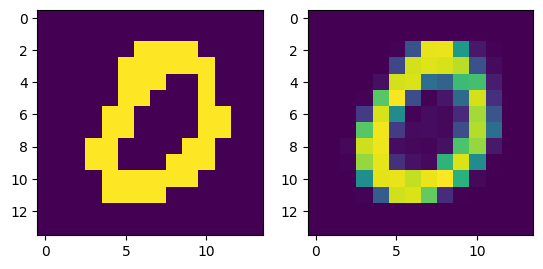

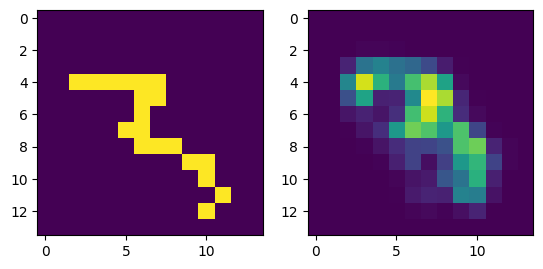

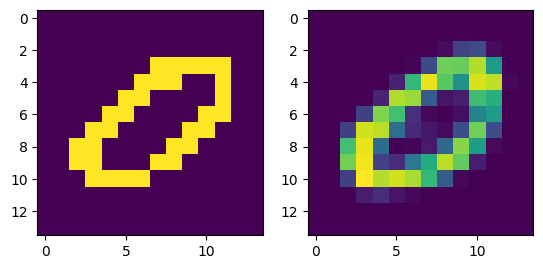

In [12]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())
     

# Visualizing input and output of the VAE from validation set

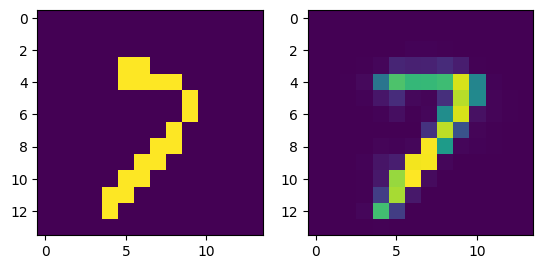

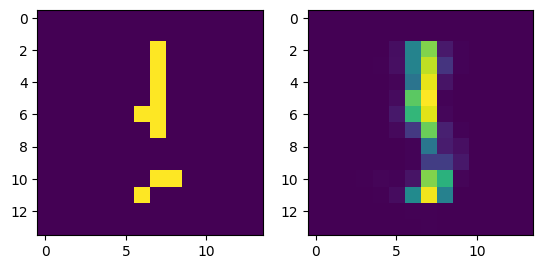

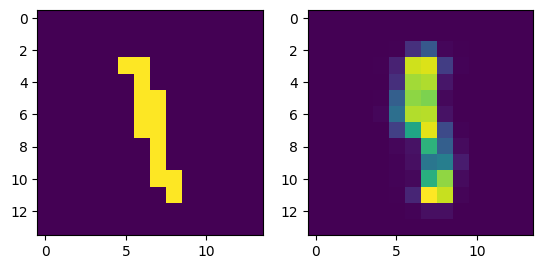

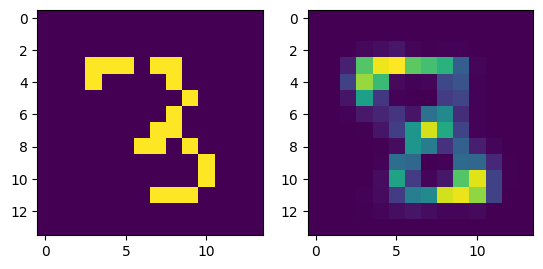

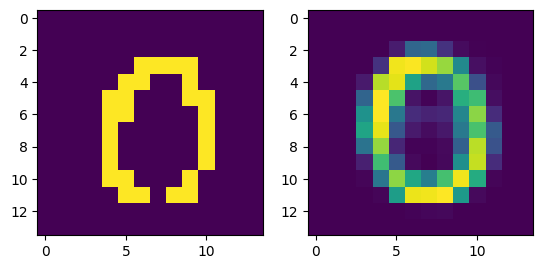

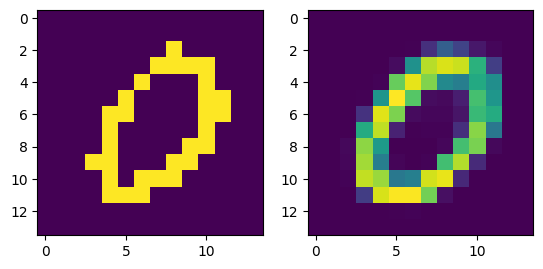

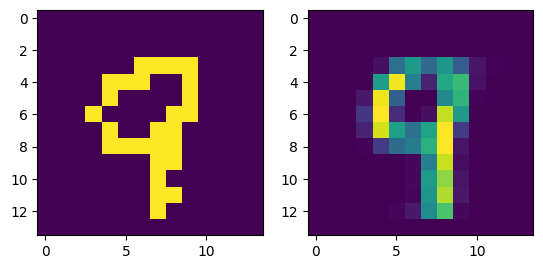

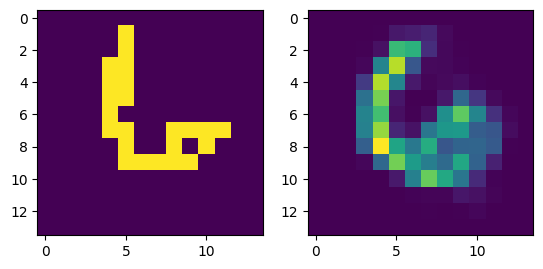

In [13]:

model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

# Synthesizing MNIST images from a Standard Gaussian Distribution

tensor([-1.3050,  1.1043, -0.3808,  0.1456, -0.2347, -0.8445, -0.6900, -0.8793],
       device='cuda:0')
tensor([-1.9343, -0.5377,  0.0495,  0.0773,  0.2341, -2.3342, -0.7727,  1.6627],
       device='cuda:0')
tensor([ 0.8418, -0.4471, -1.6538, -0.6637,  0.3504, -0.2614, -1.1730,  0.8796],
       device='cuda:0')
tensor([-0.9334,  1.5136,  1.0043, -1.7303, -0.8351,  1.7706,  0.6244, -1.1167],
       device='cuda:0')
tensor([-1.4218,  0.0522,  1.1192,  0.0944, -0.1473, -0.2737,  0.4049,  1.5818],
       device='cuda:0')
tensor([ 0.5915, -1.2693,  0.3714,  0.2782,  1.0718, -0.4366,  1.4843,  0.3727],
       device='cuda:0')
tensor([-0.3426,  0.0639,  0.5285, -1.4149, -0.3562,  1.4243, -0.8258, -0.6966],
       device='cuda:0')
tensor([-0.5345, -0.8111,  0.2081,  1.1445,  0.1918,  2.1618,  0.3087,  0.7564],
       device='cuda:0')


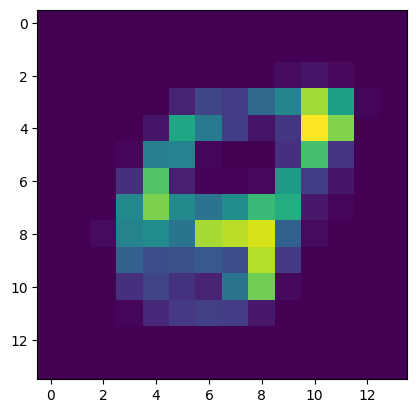

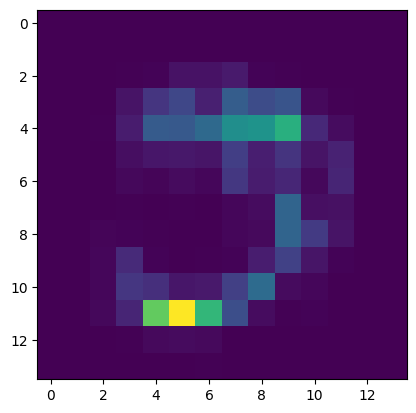

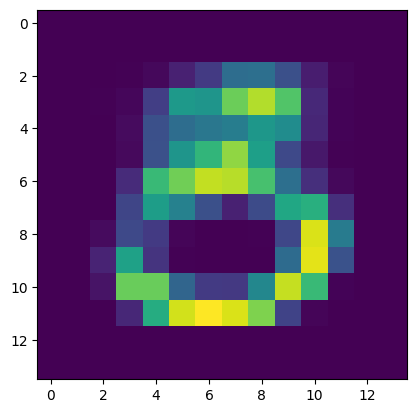

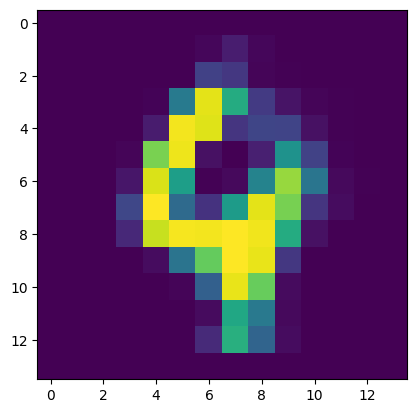

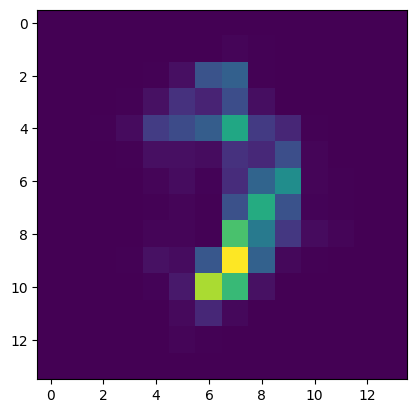

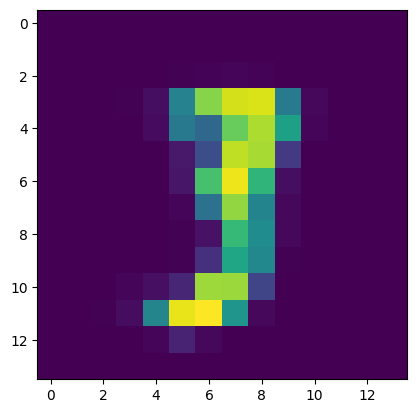

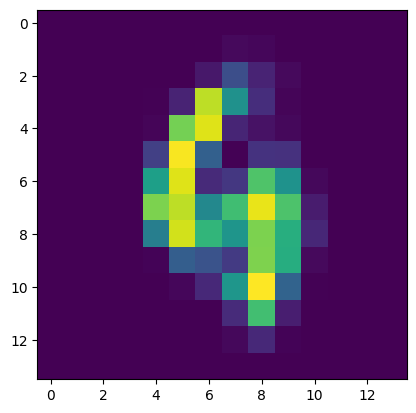

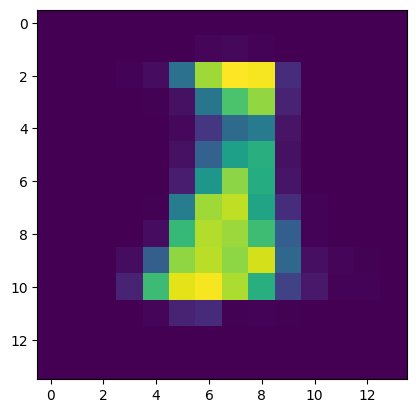

In [14]:

for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  x= x.cuda()
  recon = model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

# Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

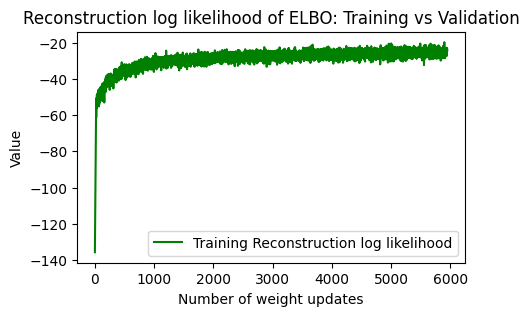

In [24]:

plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
#plt.plot(update, testl, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

In [29]:
testl_cp = [t.cpu() for t in testl]
print(type(testl[0]))
print(type(testl_cp[0]))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [31]:
testl_np = [m.detach().numpy() for m in testl_cp]
print(type(testl_np[0]))

<class 'numpy.ndarray'>


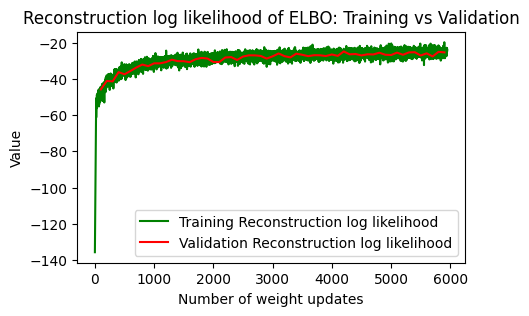

In [33]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
plt.plot(update, testl_np, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()